# AI Tensorflow Lab #2
This lab implements a linear logistic regression classifier for hand-written digits using tensorflow

In [3]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
from quiz import get_weights, get_biases, linear
from helper import plot_image_function, show_images_with_label

def mnist_features_labels(n_labels):
    """
    Gets the first <n> labels from the MNIST dataset
    :param n_labels: Number of labels to use
    :return: Tuple of feature list and label list
    """
    mnist_features = []
    mnist_labels = []

    mnist = input_data.read_data_sets('mnist_data', one_hot=True)

    # In order to make the lab run faster, we're only looking at 10000 images
    for mnist_feature, mnist_label in zip(*mnist.train.next_batch(10000)):
        # Add features and labels if it's for the first <n>th labels
        if mnist_label[:n_labels].any():
            mnist_features.append(mnist_feature)
            mnist_labels.append(mnist_label[:n_labels])

    return mnist_features, mnist_labels


f,l=mnist_features_labels(10)
print (np.shape(f))
print (np.shape(l))



Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
(10000, 784)
(10000, 10)


(10000, 28, 28)
(10000,)


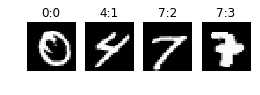

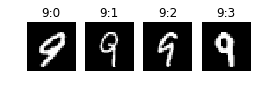

In [5]:

num=10000

f1=np.reshape(f[0:num],(num,28,28))
l1=np.argmax(l[0:num],axis=1)
print (np.shape(f1))
print (np.shape(l1))

#select 4 image randomly
plot_image_function(f1, l1, 4, 1, False)
#select 4 digit "9" randomly
show_images_with_label(f1,l1, 9 , 4, False)

In [6]:

# Number of features (28*28 image is 784 features)
n_features = 784
# Number of labels
n_labels = 10

# Features and Labels
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)


# Weights and Biases
w = get_weights(n_features, n_labels)
b = get_biases(n_labels)

# Linear Function xW + b
logits = linear(features, w, b)

# Training data features (784) and labels (one hot vector)
train_features, train_labels = mnist_features_labels(n_labels)
#print (pd.DataFrame(train_labels))
with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    # Softmax
    prediction = tf.nn.softmax(logits)

    # Calculate accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    pred = tf.argmax(prediction, axis=1)
    lab = tf.argmax(labels, axis=1)
    
    # Cross entropy
    cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

    # Training loss
    loss = tf.reduce_mean(cross_entropy)



    # Rate at which the weights are changed
    learning_rate = 0.03

    # Gradient Descent
    # This is the method used to train the model
    # You'll learn more about this in future lessons.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Run optimizer and get loss
    _, l, acc = session.run(
        [optimizer, loss, accuracy],
        feed_dict={features: train_features, labels: train_labels})


# Print loss
print('Loss: {}'.format(l))
print('accuracy:{}'.format(acc))


Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Loss: 10.518078804016113
accuracy:0.09759999811649323


# Improve the accuracy for linear regression classfication
Use mini-batches techniques to greatly improve the accuracy and reduce the cost

In [8]:

def print_epoch_stats(epoch_i, sess, cross_entropy, accuracy, last_features, last_labels, valid_features, valid_labels):
    """
    Print cost and validation accuracy of an epoch
    """
    current_cost = sess.run(
        cross_entropy,
        feed_dict={x: last_features, y_: last_labels})
    train_accuracy = sess.run(
        accuracy,
        feed_dict={x: last_features, y_: last_labels})

    valid_accuracy = sess.run(
        accuracy,
        feed_dict={x: valid_features, y_: valid_labels})
    print('Epoch: {:<4} - Cost: {:<8.3} Train Accuracy: {:<5.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        train_accuracy,
        valid_accuracy))
        

In [29]:
import tensorflow as tf

# reset everything to rerun in jupyter
tf.reset_default_graph()

# config
batch_size = 128
learning_rate = 0.5
training_epochs = 10
logs_path = "/tmp/mnist/2"

# load mnist data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# The features are already scaled and the data is shuffled
train_features = mnist.train.images
valid_features = mnist.validation.images
test_features = mnist.test.images

train_labels = mnist.train.labels.astype(np.float32)
valid_labels = mnist.validation.labels.astype(np.float32)
test_labels = mnist.test.labels.astype(np.float32)

print ("train example:", mnist.train.num_examples)
print ("valid example:", mnist.validation.num_examples)
print ("test example:", mnist.test.num_examples)


# input images
with tf.name_scope('input'):
    # None -> batch size can be any size, 784 -> flattened mnist image
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input") 
    # target 10 output classes
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

# model parameters will change during training so we use tf.Variable
with tf.name_scope("weights"):
    #W = tf.Variable(tf.zeros([784, 10]))
    W = tf.Variable(tf.random_normal([784, 10]))

# bias
with tf.name_scope("biases"):
    #b = tf.Variable(tf.zeros([10]))
    b = tf.Variable(tf.random_normal([10]))

    
# logits
with tf.name_scope("logit"):
    logit = tf.matmul(x,W) + b

# implement model
with tf.name_scope("softmax"):
    # y is our prediction
    y = tf.nn.softmax(logit)

# specify cost function
with tf.name_scope('cross_entropy'):
    # this is our cost
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# specify optimizer
with tf.name_scope('train'):
    # optimizer is an "operation" which we can execute in a session
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('Accuracy'):
    # Accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    prediction = tf.argmax(y,1)
    groundtruth = tf.argmax(y_,1)
    
init = tf.global_variables_initializer()

use_tf_batch=True

with tf.Session() as sess:
    # variables need to be initialized before we can use them
    sess.run(init)
        
    # perform training cycles
    for epoch in range(training_epochs):
        if use_tf_batch==False:
            train_features, train_labels = shuffle(train_features, train_labels)
            train_batches = gen_batches(batch_size, train_features, train_labels)
        # number of batches in one epoch
        batch_count = int(mnist.train.num_examples/batch_size)
        
        for i in range(batch_count):
        # method 1: use gen_batches
            if use_tf_batch==False:
                batch_x, batch_y = train_batches[i]
        # method 2: use tensorflow functions
            else:
                batch_x, batch_y = mnist.train.next_batch(batch_size)

            # perform the operations we defined earlier on batch
            _ = sess.run([train_op], feed_dict={x: batch_x, y_: batch_y})
        print_epoch_stats(epoch, sess, cross_entropy, accuracy, train_features, train_labels, valid_features, valid_labels)    
    print ("Accuracy: ", accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
    print ("done")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
train example: 55000
valid example: 5000
test example: 10000
Epoch: 0    - Cost: 0.783    Train Accuracy: 0.84  Valid Accuracy: 0.847
Epoch: 1    - Cost: 0.605    Train Accuracy: 0.865 Valid Accuracy: 0.875
Epoch: 2    - Cost: 0.526    Train Accuracy: 0.876 Valid Accuracy: 0.881
Epoch: 3    - Cost: 0.471    Train Accuracy: 0.888 Valid Accuracy: 0.891
Epoch: 4    - Cost: 0.437    Train Accuracy: 0.892 Valid Accuracy: 0.894
Epoch: 5    - Cost: 0.413    Train Accuracy: 0.897 Valid Accuracy: 0.9  
Epoch: 6    - Cost: 0.391    Train Accuracy: 0.902 Valid Accuracy: 0.902
Epoch: 7    - Cost: 0.391    Train Accuracy: 0.898 Valid Accuracy: 0.9  
Epoch: 8    - Cost: 0.363    Train Accuracy: 0.905 Valid Accuracy: 0.903
Epoch: 9    - Cost: 0.352    Train Accuracy: 0.908 Valid Accuracy: 0.906
Accuracy:  0.90

### Quiz: [Optional] Write a function to implement the mini-batch 

### Add Tensorboard to visualize the training process
Learn to use name scope to organize the variables in the tensor graph; use tensor summery operation to record scalar, histogram and image data.

Use Saver function to save model and restore it later.


In [31]:
import tensorflow as tf
from quiz import * 
# reset everything to rerun in jupyter
tf.reset_default_graph()

# config
batch_size = 128
learning_rate = 0.5
training_epochs = 20
logs_path = "/tmp/mnist/2"

# load mnist data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# The features are already scaled and the data is shuffled
train_features = mnist.train.images
valid_features = mnist.validation.images
test_features = mnist.test.images

train_labels = mnist.train.labels.astype(np.float32)
valid_labels = mnist.validation.labels.astype(np.float32)
test_labels = mnist.test.labels.astype(np.float32)


# input images
with tf.name_scope('input'):
    # None -> batch size can be any size, 784 -> flattened mnist image
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input") 
    # target 10 output classes
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

# model parameters will change during training so we use tf.Variable
with tf.name_scope("weights"):
    #W = tf.Variable(tf.zeros([784, 10]))
    W = tf.Variable(tf.random_normal([784, 10]))


# bias
with tf.name_scope("biases"):
    #b = tf.Variable(tf.zeros([10]))
    b = tf.Variable(tf.random_normal([10]))

    
# logits
with tf.name_scope("logit"):
    logit = tf.matmul(x,W) + b

# implement model
with tf.name_scope("softmax"):
    # y is our prediction
    y = tf.nn.softmax(logit)


# specify cost function
with tf.name_scope('cross_entropy'):
    # this is our cost
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# specify optimizer
with tf.name_scope('train'):
    # optimizer is an "operation" which we can execute in a session
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('Accuracy'):
    # Accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    prediction = tf.argmax(y,1)
    groundtruth = tf.argmax(y_,1)

    
# create a summary for our cost and accuracy
tf.summary.scalar("cost", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
tf.summary.histogram("weights", W)
tf.summary.image('image',np.reshape(train_features,[55000,28,28,1]), max_outputs=10)
print ("train example:", mnist.train.num_examples)
print ("valid example:", mnist.validation.num_examples)
print ("test example:", mnist.test.num_examples)

# merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.summary.merge_all()
init = tf.global_variables_initializer()

# Two methods to generate the batches
# method 1: use helper functions gen_batches
# method 2: use tensor flow library functions


use_tf_batch=False
saver = tf.train.Saver()
with tf.Session() as sess:
    # variables need to be initialized before we can use them
    sess.run(init)

    # create log writer object
    writer = tf.summary.FileWriter(logs_path, sess.graph)

        
    # perform training cycles
    for epoch in range(training_epochs):
        if use_tf_batch==False:
            train_features, train_labels = shuffle(train_features, train_labels)
            train_batches = gen_batches(batch_size, train_features, train_labels)
        # number of batches in one epoch
        batch_count = int(mnist.train.num_examples/batch_size)
        for i in range(batch_count):
        # method 1: use gen_batches
            if use_tf_batch==False:
                batch_x, batch_y = train_batches[i]
        # method 2: use tensorflow functions
            else:
                batch_x, batch_y = mnist.train.next_batch(batch_size)
            
            # perform the operations we defined earlier on batch
            _, summary_1 = sess.run([train_op, summary_op], feed_dict={x: batch_x, y_: batch_y})
            # write log
        summary = sess.run(summary_op, feed_dict={x: train_features, y_: train_labels})
        writer.add_summary(summary, epoch)
        print_epoch_stats(epoch, sess, cross_entropy, accuracy, train_features, train_labels, valid_features, valid_labels)    
    print ("Test Accuracy: ", accuracy.eval(feed_dict={x: test_features, y_: test_labels}))
    print ("Train Accuracy: ", accuracy.eval(feed_dict={x: train_features, y_: train_labels}))
    print ("Valid Accuracy: ", accuracy.eval(feed_dict={x: valid_features, y_: valid_labels}))
    writer.close()
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)
    print ("done")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
train example: 55000
valid example: 5000
test example: 10000
Epoch: 0    - Cost: 0.72     Train Accuracy: 0.846 Valid Accuracy: 0.856
Epoch: 1    - Cost: 0.574    Train Accuracy: 0.871 Valid Accuracy: 0.876
Epoch: 2    - Cost: 0.499    Train Accuracy: 0.884 Valid Accuracy: 0.893
Epoch: 3    - Cost: 0.459    Train Accuracy: 0.891 Valid Accuracy: 0.897
Epoch: 4    - Cost: 0.429    Train Accuracy: 0.894 Valid Accuracy: 0.899
Epoch: 5    - Cost: 0.407    Train Accuracy: 0.899 Valid Accuracy: 0.901
Epoch: 6    - Cost: 0.395    Train Accuracy: 0.901 Valid Accuracy: 0.906
Epoch: 7    - Cost: 0.376    Train Accuracy: 0.905 Valid Accuracy: 0.907
Epoch: 8    - Cost: 0.361    Train Accuracy: 0.908 Valid Accuracy: 0.91 
Epoch: 9    - Cost: 0.359    Train Accuracy: 0.907 Valid Accuracy: 0.907
Epoch: 10   - C

## Confusion Matrix
By definition a confusion matrix C is such that C_{i, j} is equal to the number of observations known to be in group i but predicted to be in group j.

We will use skilearn library to generate the confusion matrix to evaluate the accuracy of the classification.

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
from helper import plot_confusion_matrix
with tf.name_scope('ConfMat'):
    prediction = tf.argmax(y,1)
    groundtruth = tf.argmax(y_,1)
feature_size=len(test_features)
X_in=test_features
y_in=test_labels
with tf.Session() as sess:
    #sess.run(init)
    saver.restore(sess, "/tmp/model.ckpt")
    [g,p,c]=sess.run([groundtruth,prediction,accuracy],feed_dict={x:X_in,y_:y_in})

cm=confusion_matrix(g,p)
print (cm)


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
[[ 943    0    1    3    0   20    8    2    2    1]
 [   0 1102    6    4    1    3    4    3   12    0]
 [   5   12  906   19    7   13   15   13   37    5]
 [   3    1   22  894    1   50    3   11   18    7]
 [   1    2    7    3  909    1   15    8    8   28]
 [   7    1    4   27    8  798   18    5   18    6]
 [   8    2    7    2    9   17  909    3    1    0]
 [   2    8   24   10    9    3    0  946    1   25]
 [   8   10    9   26    8   62   16   11  810   14]
 [   9    7    0    8   35   14    0   38    5  893]]


### Visualize the Confusion Matrix using plot
use plot function to plot confusion matrix. The function is got and modified from scikit-learn.org

Normalized confusion matrix


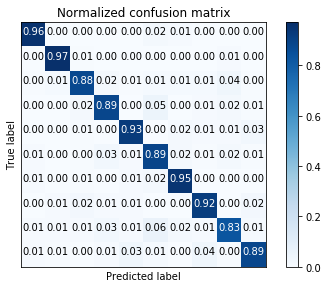

In [27]:

plot_confusion_matrix(cm, classes="", normalize=True,
                      title='Normalized confusion matrix')



## Quiz: Write a function to implement confunsion matrix

In [23]:
confusion_matrix_np = np.array([[len([k for k in range(feature_size) if p[k]==j and g[k]==i]) for j in range(10) ] for i in range(10)])
print (confusion_matrix_np)

[[ 952    0    1    3    0   15    6    2    1    0]
 [   0 1116    2    2    0    4    4    1    6    0]
 [  14   27  880   24    3   12   16   14   34    8]
 [   7    1   20  868    0   71    4   14   14   11]
 [   0    4    6    2  882    8   15    7    8   50]
 [   8    4    4   21    9  802   12    4   22    6]
 [  19    5    9    0   10   31  880    1    3    0]
 [   3   13   18    7    9    2    0  935    3   38]
 [   7   21    7   33    9   88   15    7  770   17]
 [   9    8    1   11   35   17    2   21    7  898]]
